# Exploring stars in the CVZs.

Trying to figure out how many stars of each spectral type are in the CVZs, using queries sent via CasJobs.

In [6]:
%matplotlib inline

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
north = pd.read_csv("../../data/cvz_north_16th.csv")
south = pd.read_csv("../../data/cvz_south_16th.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,115) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
print(len(south), len(north), len(south) + len(north))
nbright, sbright = north.Tmag.values < 15, south.Tmag.values < 15
print(len(north.iloc[nbright]), len(south.iloc[sbright]), len(north.iloc[nbright]) + len(south.iloc[sbright]))

533829 488865 1022694
246223 262035 508258


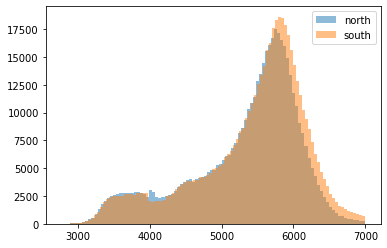

In [10]:
plt.hist(north.Teff, 100, alpha=.5, label="north");
plt.hist(south.Teff, 100, alpha=.5, label="south");
plt.legend()

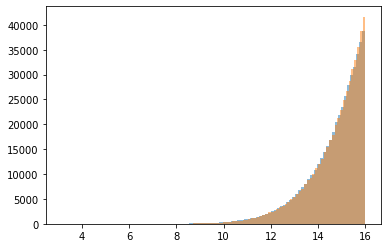

In [11]:
plt.hist(north.Tmag, 100, alpha=.5);
plt.hist(south.Tmag, 100, alpha=.5);

In [12]:
cool = south.Teff.values < 4000
print(sum(cool))
cool = north.Teff.values < 4000
print(sum(cool))

44315
45435


Load the KIC to compare.

In [13]:
from astropy.io import fits

gaia_file = "/Users/rangus/projects/data/kepler_dr2_1arcsec.fits"

with fits.open(gaia_file) as data:
    kepler = pd.DataFrame(data[1].data, dtype="float64")

In [14]:
df = pd.merge(north, south, on=["ID", "Teff"], how="outer")
print(sum(df.Teff.values < 4000))
print(sum(df.Teff.values < 4000))
print(sum(kepler.teff.values < 4000))

89750
89750
6288


Text(0, 0.5, 'Number of stars')

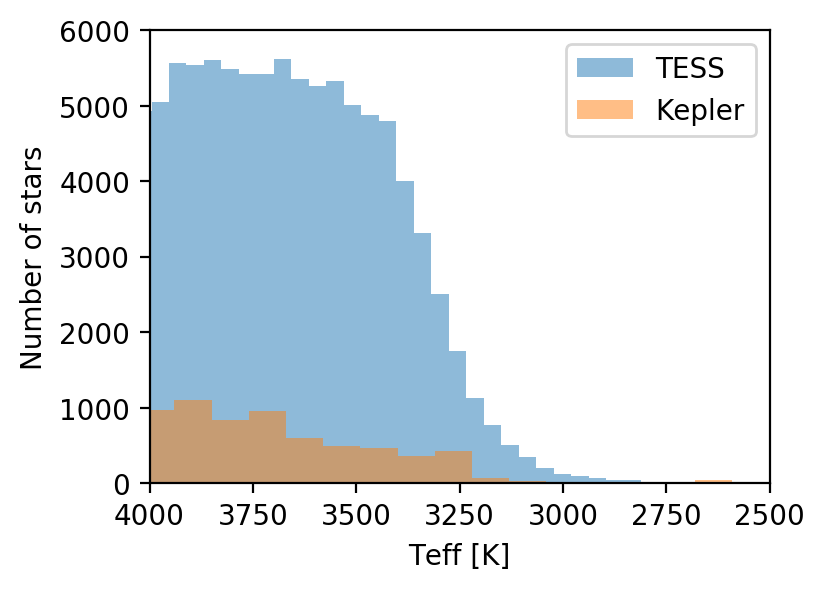

In [15]:
plt.figure(figsize=(4, 3), dpi=200)
plt.hist(df.Teff, 100, density=False, alpha=.5, label="TESS");
plt.hist(kepler.teff.values[kepler.teff.values < 7000], 50, density=False, alpha=.5, label="Kepler");
plt.legend()
plt.gca().invert_xaxis()
plt.xlim(4000, 2500)
plt.ylim(0, 6000)
plt.xlabel("Teff [K]")
plt.ylabel("Number of stars")

In [16]:
print(north.ra.values[:10])
print(north.dec.values[:10])

[251.11291361 246.43175633 248.71603491 243.8037382  244.70346351
 244.69276777 249.33497539 249.9593778  250.02744819 248.49587661]
[63.27319422 62.22356768 64.09808423 63.55002236 66.64794872 67.00833243
 65.03404697 69.46232454 70.70600953 59.7401828 ]


63.2731942219403 251.112913610498


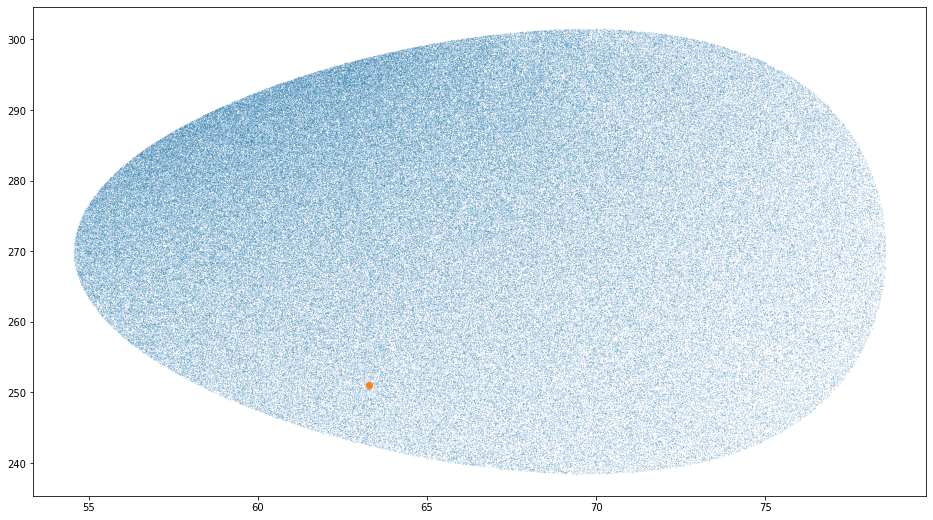

In [17]:
plt.figure(figsize=(16, 9))
plt.plot(north.dec.values, north.ra.values, ".", ms=.1)
plt.plot(north.dec.values[0], north.ra.values[0], "o")
print(north.dec.values[0], north.ra.values[0])

In [18]:
bright_m_dwarfs = (north.Vmag.values < 14) & (north.Vmag.values > 13) & (north.Teff.values < 3500)
south_bright_m_dwarfs = (south.Vmag.values < 14) & (south.Vmag.values > 13) & (south.Teff.values < 3500)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [20]:
print(north.ID.values[bright_m_dwarfs])
print(south.ID.values[south_bright_m_dwarfs])

[219751364 219877118 406857100 441734910 269596978 229480400 420112587
 243315463 230394587 424388625 229642180 233532220 233726162 229609853
 233721982 233738219 233738446 289536553 284892663 459985740 441717812
 359313701 441721594 233068870 219884888 198235884 232618367 230076546]
[150428135 167721744 176954932 389561485 167306154 177386111  55399276
  38759628  33864387  55498515 260189849 149988104 277102246 167338863
 220432563]


In [21]:
northern_bright_mdwarfs = north.iloc[bright_m_dwarfs]
northern_bright_mdwarfs.to_csv("bright_north_CVZ_Mdwarfs.csv")

southern_bright_mdwarfs = south.iloc[south_bright_m_dwarfs]
southern_bright_mdwarfs.to_csv("bright_south_CVZ_Mdwarfs.csv")

In [22]:
from tess_stars2px import tess_stars2px_function_entry

In [23]:
ra = north.ra.values[bright_m_dwarfs]
dec = north.dec.values[bright_m_dwarfs]
ticid = north.ID.values[bright_m_dwarfs]

ra = south.ra.values[south_bright_m_dwarfs]
dec = south.dec.values[south_bright_m_dwarfs]
ticid = south.ID.values[south_bright_m_dwarfs]

outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
    tess_stars2px_function_entry(ticid[0], ra[0], dec[0])

In [24]:
outID, outSec

(array([150428135, 150428135, 150428135, 150428135, 150428135, 150428135,
        150428135, 150428135, 150428135, 150428135, 150428135, 150428135,
        150428135, 150428135, 150428135, 150428135, 150428135, 150428135,
        150428135, 150428135, 150428135]),
 array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 27, 28, 30, 31, 33, 34,
        35, 36, 37, 38]))

In [25]:
for i in range(sum(bright_m_dwarfs)):
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
        tess_stars2px_function_entry(ticid[i], ra[i], dec[i], scInfo=scinfo)
    print(outID[0])
    print(outSec, "\n")

150428135
[ 1  3  4  5  6  7  8  9 10 11 13 27 28 30 31 33 34 35 36 37 38] 

167721744
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 36 37 38
 39] 

176954932
[ 2  3  4  5  6  7  8  9 10 12 13 27 28 29 30 31 32 33 34 35 36 37 38 39] 

389561485
[ 1  2  3  4  5  6  8  9 10 11 12 13 28 29 30 31 32 33 34 35 36 38 39] 

167306154
[ 1  2  4  5  6  7  8  9 10 11 12 27 28 29 31 32 34 35 36 37 38 39] 

177386111
[ 1  2  3  4  5  6  7  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37 38
 39] 

55399276
[ 1  2  3  4  5  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 37 38 39] 

38759628
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 31 32 33 34 35 36 37 38
 39] 

33864387
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37
 38 39] 

55498515
[ 1  2  4  5  6  7  8  9 10 11 12 27 28 29 30 31 32 34 35 36 37 38 39] 

260189849
[ 1  2  4  5  6  7  8  9 10 11 12 27 28 29 30 31 32 34 35 36 37 38 39] 

149988104
[ 1  2  3  4  5  7  8  9 10 11 12 13 27 28 29 30 31 3

IndexError: index 15 is out of bounds for axis 0 with size 15

In [22]:
# import lightkurve as lk

# from lightkurve import search_targetpixelfile
# # First we open a Target Pixel File from MAST, this one is already cached from our previous tutorial!
# tpf = search_targetpixelfile('TIC 219740029').download()

# # Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
# lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

# import lightkurve as lk
# lc = lk.search_lightcurvefile("TIC 219740029", mission="TESS", sector=14).download().PDCSAP_FLUX

Load ASAS-SN data.

In [30]:
asas = pd.read_csv("../../data/asas-sn_cvz_north.csv")
# asas.distance_as

Calculate tangential distance

In [31]:
def tang_dist(ra1, ra2, dec1, dec2):
    delta_ra, delta_dec = ra1 - ra2, dec1 - dec2
    return np.sqrt(delta_ra**2 + delta_dec**2)

In [32]:
td = tang_dist(asas.ra, north.ra, asas.dec, north.dec)

In [34]:
min_ind = np.argmin(td.values)

In [35]:
min_ind

31

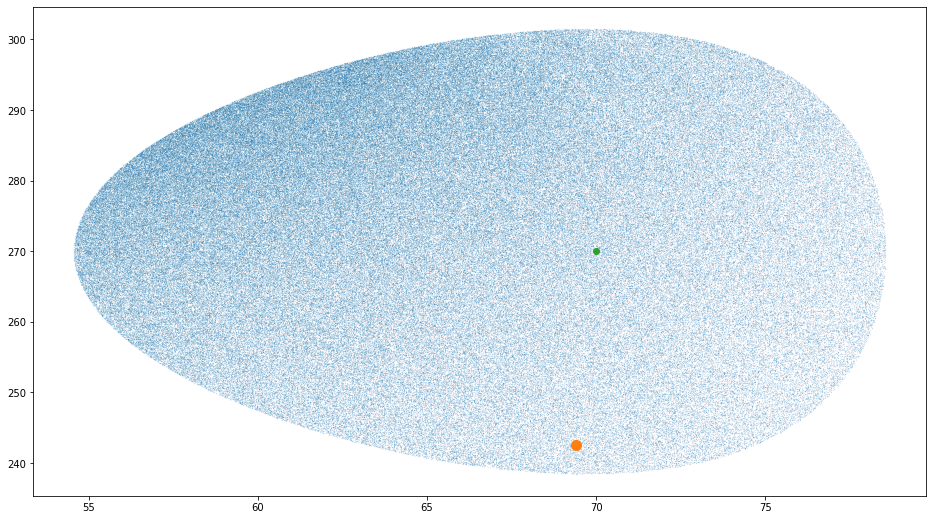

In [38]:
plt.figure(figsize=(16, 9))
plt.plot(north.dec.values, north.ra.values, ".", ms=.1)
plt.plot(north.dec.values[min_ind], north.ra.values[min_ind], "C1o", ms=10)
plt.plot(asas.dec.values[0], asas.ra.values[0], "C2o")

In [4]:
import eleanor
star = eleanor.Source(tic=38846515, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  1...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  1 now available.
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.9597092399964, and Dec -64.0270368810381
